#### Project Overview

This is the first Captone project for SpringBoard using the UCI dataset: Diabetes 130-US hospitals for years 1999-2008 Data Set. Detailed description of the dataset can be found here - https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008.

### Step One - Data Wrangling
First step is to read in the CSV file and explore the data to check for:
1) non-numerical values
2) missing cells

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_raw=pd.read_csv('/Users/YingShen/Desktop/Data_Science/SpringBorad/Git/dataset_diabetes/diabetic_data.csv')

#### I. Feature selection
Before using Pandas to do data wrangling, EXCEL itself can be useful to filter out some features that have too many missingness, including:

weight: 98569;
payer_code: 40256;
medical_specialty: 49949

In addition, 24 features of medications are not used neither since there is one variable that can represent all of them.

In [5]:
# Select the features we need to process
df=df_raw[['patient_nbr', 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'change', 'diabetesMed', 'readmitted']] 

# Same patienets are highly correlated with themselves and should be dropped
df.drop_duplicates(subset=["patient_nbr"],inplace=True) 

'''First get a general information of the variables left'''
print(df.info()) # 71518 obs; 23 columns; int64(12), object(11); all non-null

'''Then explore the variables in the dataset'''
print(df.describe().loc[['mean','min','max']])
print(df.describe(exclude=np.number))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 23 columns):
patient_nbr                 71518 non-null int64
race                        71518 non-null object
gender                      71518 non-null object
age                         71518 non-null object
admission_type_id           71518 non-null int64
discharge_disposition_id    71518 non-null int64
admission_source_id         71518 non-null int64
time_in_hospital            71518 non-null int64
num_lab_procedures          71518 non-null int64
num_procedures              71518 non-null int64
num_medications             71518 non-null int64
number_outpatient           71518 non-null int64
number_emergency            71518 non-null int64
number_inpatient            71518 non-null int64
diag_1                      71518 non-null object
diag_2                      71518 non-null object
diag_3                      71518 non-null object
number_diagnoses            71518 non-null int64
ma

In [6]:
# There are 11 string features that need to be transformed
# Define the lambda function: categorize_label
# categorize_label = lambda x: x.astype('category')

# # Convert df[categories] to a categorical type (to be more efficient)
# categories=['race', 'gender', 'age','diag_1','diag_2', 'diag_3', 
#              'max_glu_serum', 'A1Cresult','change', 'diabetesMed', 'readmitted']
# df[categories] = df[categories].apply(categorize_label)
# print(df[categories].dtypes)

In [7]:
# I will transform ICD diagnosis codes later into Charlson Comorbidity Score;
# Here let's check the values of the non-null categorical variables
cat2=['race', 'gender', 'age','max_glu_serum', 'A1Cresult','change', 'diabetesMed', 'readmitted']

for i in cat2:
    print(df[i].value_counts())

Caucasian          53491
AfricanAmerican    12887
?                   1948
Hispanic            1517
Other               1178
Asian                497
Name: race, dtype: int64
Female             38025
Male               33490
Unknown/Invalid        3
Name: gender, dtype: int64
[70-80)     18210
[60-70)     15960
[50-60)     12466
[80-90)     11589
[40-50)      6878
[30-40)      2699
[90-100)     1900
[20-30)      1127
[10-20)       535
[0-10)        154
Name: age, dtype: int64
None    68062
Norm     1731
>200      969
>300      756
Name: max_glu_serum, dtype: int64
None    58532
>8       6304
Norm     3791
>7       2891
Name: A1Cresult, dtype: int64
No    39494
Ch    32024
Name: change, dtype: int64
Yes    54319
No     17199
Name: diabetesMed, dtype: int64
NO     42985
>30    22240
<30     6293
Name: readmitted, dtype: int64


In [8]:
''' Transform strings to dummy values '''

# There are 3 invalid/unknown cells in gender; just delete them
df["gender_d"]=df["gender"].apply(lambda x: 1 if x=="Male" else 0) 
df=df[df['gender']!="Unknown/Invalid"]

# Transform age category into norminal variables
age_dict={"[0-10)":1,"[10-20)":2,"[20-30)":3,"[30-40)":4,"[40-50)":5,"[50-60)":6,
          "[60-70)":7,"[70-80)":8,"[80-90)":9,"[90-100)":10}
df["age_mapped"]=df["age"].map(age_dict)

# Transform question mark in race into "other" category
df['race']=df['race'].apply(lambda x: "Other" if x=="?" else x)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### Some numerical variables actually have categorical meanings: 
#### 1. discharge_disposition_id:  indicates discharge status
First, patients who were discharged dead will be excluded from the study; then, we will create a new variable indicating if the patients were discharged home or not
#### 2. admis_source_group:  indicates admission type

In [9]:
# Drop encounters that ended in deaths or hospice
df=df[df['discharge_disposition_id'].isin([11,13,14,19,20,21])==False]
df['dischar_home']=df['discharge_disposition_id'].apply(lambda x: 1 if x==1 or x==6 or x==8 else 0)

In [10]:
# Categorize admission source codes into 1: emergency; 2: referral; 3: other
def ad_cource_group(value):
    if value==7 or value==25:
        return 1
    if 1<=value<=6 or value==10 or value==18 or value==22 or value==26:
        return 2
    else: return 3
df['admis_source_group']=df['admission_source_id'].apply(ad_cource_group)

####  Transform other categorical variables into dummy variables

In [11]:
df['max_glu_dummy']=df['max_glu_serum'].apply(lambda x: 0 if x=="None" else 1)
df['A1Cresult_dummy']=df['A1Cresult'].apply(lambda x: 0 if x=="None" else 1)
df['change_d']=df['change'].apply(lambda x: 1 if x=="Ch" else 0)
df['diabetesMed_d']=df['diabetesMed'].apply(lambda x: 1 if x=="Yes" else 0)
df['readmitted_d']=df['readmitted'].apply(lambda x: 1 if x=="<30" else 0)
df[["African_American","Asian","Caucasian","Hispanic","Other"]]=pd.get_dummies(df['race'])

#### Charlson Comorbidity Score from ICD-9-CM diagnosis codes
Diagnosis codes are useful to indicate the severity of illness a patient has, which is a common way of adjusting health conditions of a patient in academia

In [12]:
''' Transform diagnosis codes into meaning CCI scores using regular expression '''
# Diagnosis 1
df["MI_CHF_Cereb_Dem_1"]=df['diag_1'].str.match(r'(41[02][.]?\d?\d?)|(428[.]?\d?\d?)|(43[0-8][.]?\d?\d?)|(290[.]?\d?\d?)')
df["PVF_1"]=df['diag_1'].str.match(r'(443[.]9\d?)|(441[.]?\d?\d?)|(785[.]4\d?)|(V43[.]4\d?)')
df["ChroPul_1"]=df['diag_1'].str.match(r'((49[0-9])|(50[0-5])[.]?\d?\d?)|(506.4\d?)')
df["Rheu_1"]=df['diag_1'].str.match(r'(710[.][014]])|(714[.][02])|(714[.]81)|(724[.]?\d?\d?)')
df["PepUlc_Liver_Diabetes_1"]=df['diag_1'].str.match(r'(53[1-4][.]?\d?\d?)|(571[.][2456]\d?)|(250[.][01237]\d?)')
df["Hemip_Diabetes_1"]=df['diag_1'].str.match(r'(250[.][456]\d?)|(344[.]1\d?)|(342[.]?\d?\d?)|(250)')
df["Renal_1"]=df['diag_1'].str.match(r'58[23568][.]?\d?\d?')
df["Cancer_1"]=df['diag_1'].str.match(r'(1[4-6][0-9][.]?\d?\d?)|(17[0-2][.]?\d?\d?)|(17[4-9][.]?\d?\d?)|\
                                      (18[0-9][.]?\d?\d?)|(195[.]8)|(20[0-8][.]?\d?\d?)')          
df["Liver_1"]=df['diag_1'].str.match(r'(456[.][01][0-9]?)|(456[.]2[01])|(572[.][2-8]\d?)')
df["Metas_1"]=df['diag_1'].str.match(r'(19[6-8][.]?\d?\d?)|(199[.]1)')
df["HIV_1"]=df['diag_1'].str.match(r'04[2-4][.]?\d?\d?')

# Diagnosis 2
df["MI_CHF_Cereb_Dem_2"]=df['diag_2'].str.match(r'(41[02][.]?\d?\d?)|(428[.]?\d?\d?)|(43[0-8][.]?\d?\d?)|(290[.]?\d?\d?)')
df["PVF_2"]=df['diag_2'].str.match(r'(443[.]9\d?)|(441[.]?\d?\d?)|(785[.]4\d?)|(V43[.]4\d?)')
df["ChroPul_2"]=df['diag_2'].str.match(r'((49[0-9])|(50[0-5])[.]?\d?\d?)|(506.4\d?)')
df["Rheu_2"]=df['diag_2'].str.match(r'(710[.][014]])|(714[.][02])|(714[.]81)|(724[.]?\d?\d?)')
df["PepUlc_Liver_Diabetes_2"]=df['diag_2'].str.match(r'(53[1-4][.]?\d?\d?)|(571[.][2456]\d?)|(250[.][01237]\d?)')
df["Hemip_Diabetes_2"]=df['diag_2'].str.match(r'(250[.][456]\d?)|(344[.]1\d?)|(342[.]?\d?\d?)|(250)')
df["Renal_2"]=df['diag_2'].str.match(r'58[23568][.]?\d?\d?')
df["Cancer_2"]=df['diag_2'].str.match(r'(1[4-6][0-9][.]?\d?\d?)|(17[0-2][.]?\d?\d?)|(17[4-9][.]?\d?\d?)|\
                                      (18[0-9][.]?\d?\d?)|(195[.]8)|(20[0-8][.]?\d?\d?)')          
df["Liver_2"]=df['diag_2'].str.match(r'(456[.][01][0-9]?)|(456[.]2[01])|(572[.][2-8]\d?)')
df["Metas_2"]=df['diag_2'].str.match(r'(19[6-8][.]?\d?\d?)|(199[.]1)')
df["HIV_2"]=df['diag_2'].str.match(r'04[2-4][.]?\d?\d?')

# Diagnosis 3
df["MI_CHF_Cereb_Dem_3"]=df['diag_3'].str.match(r'(41[02][.]?\d?\d?)|(428[.]?\d?\d?)|(43[0-8][.]?\d?\d?)|(290[.]?\d?\d?)')
df["PVF_3"]=df['diag_3'].str.match(r'(443[.]9\d?)|(441[.]?\d?\d?)|(785[.]4\d?)|(V43[.]4\d?)')
df["ChroPul_3"]=df['diag_3'].str.match(r'((49[0-9])|(50[0-5])[.]?\d?\d?)|(506.4\d?)')
df["Rheu_3"]=df['diag_3'].str.match(r'(710[.][014]])|(714[.][02])|(714[.]81)|(724[.]?\d?\d?)')
df["PepUlc_Liver_Diabetes_3"]=df['diag_3'].str.match(r'(53[1-4][.]?\d?\d?)|(571[.][2456]\d?)|(250[.][01237]\d?)')
df["Hemip_Diabetes_3"]=df['diag_3'].str.match(r'(250[.][456]\d?)|(344[.]1\d?)|(342[.]?\d?\d?)|(250)')
df["Renal_3"]=df['diag_3'].str.match(r'58[23568][.]?\d?\d?')
df["Cancer_3"]=df['diag_3'].str.match(r'(1[4-6][0-9][.]?\d?\d?)|(17[0-2][.]?\d?\d?)|(17[4-9][.]?\d?\d?)|\
                                      (18[0-9][.]?\d?\d?)|(195[.]8)|(20[0-8][.]?\d?\d?)')          
df["Liver_3"]=df['diag_3'].str.match(r'(456[.][01][0-9]?)|(456[.]2[01])|(572[.][2-8]\d?)')
df["Metas_3"]=df['diag_3'].str.match(r'(19[6-8][.]?\d?\d?)|(199[.]1)')
df["HIV_3"]=df['diag_3'].str.match(r'04[2-4][.]?\d?\d?')

In [13]:
df['Score_1']=(df['MI_CHF_Cereb_Dem_1']+df["PVF_1"]+df["ChroPul_1"]+df["Rheu_1"]+df["PepUlc_Liver_Diabetes_1"])*1+\
            (df["Hemip_Diabetes_1"]+df["Renal_1"]+df["Cancer_1"])*2+(df["Liver_1"])*3+(df["Metas_1"]+df["HIV_1"])*6

df['Score_2']=(df['MI_CHF_Cereb_Dem_2']+df["PVF_2"]+df["ChroPul_2"]+df["Rheu_2"]+df["PepUlc_Liver_Diabetes_2"])*1+\
            (df["Hemip_Diabetes_2"]+df["Renal_2"]+df["Cancer_2"])*2+(df["Liver_2"])*3+(df["Metas_2"]+df["HIV_2"])*6

df['Score_3']=(df['MI_CHF_Cereb_Dem_3']+df["PVF_3"]+df["ChroPul_3"]+df["Rheu_3"]+df["PepUlc_Liver_Diabetes_3"])*1+\
            (df["Hemip_Diabetes_3"]+df["Renal_3"]+df["Cancer_3"])*2+(df["Liver_3"])*3+(df["Metas_3"]+df["HIV_3"])*6
df['CCI']=df['Score_1']+df['Score_2']+df['Score_3']
df['CCI'].mean()

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


1.576875803915964

In [14]:
# Will keep race and gender for now for visualization
cleaned_df=df[["race","Caucasian","African_American","Other","Hispanic","Asian", 'gender','gender_d', 'age_mapped', 
               'dischar_home','admis_source_group',
               'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
               'num_medications','number_outpatient', 'number_emergency', 
               'number_inpatient', 'CCI', 'number_diagnoses', 
               'max_glu_dummy', 'A1Cresult_dummy','change_d', 'diabetesMed_d', 'readmitted_d']]
cleaned_df.shape

(69970, 25)

### Step Two - Exploratory Data Analysis
Several Preliminary Questions to Ask :

1. Since this is a claims study regarding a clinical outcome (readmission), patient characteristics should be strong indicators for the outcome; is it the case for the patient characteristics included in this study?
2. As commonly observed in clinical studies, exposure variables can have interactive impact on each other; How can I have a preliminary analysis of that?
3. What plots can I make to visually help me identify potential trend and relationship among all given variables and the target outcome? What plots are appropriate given the data type?

Considering that the outcome variable is 1 or 0, and most predictors are categorical, barcharts of the outcome percentages would be useful to visualize difference of occurrence among different groups.
To answer the above questions, following plots using the sns.countplot were made:

In [15]:
# Using groupby objects to generate readmission rates of each categories

age_race=cleaned_df.groupby(['age_mapped','race'])['readmitted_d'].mean()
age_race_df=pd.DataFrame(age_race)
age_race_df=age_race_df.reset_index()

gender_disc=cleaned_df.groupby(['gender','dischar_home'])['readmitted_d'].mean()
gender_disc_df=pd.DataFrame(gender_disc)
gender_disc_df=gender_disc_df.reset_index()

age_adm=cleaned_df.groupby(['age_mapped','admis_source_group'])['readmitted_d'].mean()
age_adm_df=pd.DataFrame(age_adm)
age_adm_df=age_adm_df.reset_index()

age_glu=cleaned_df.groupby(['age_mapped','max_glu_dummy'])['readmitted_d'].mean()
age_glu_df=pd.DataFrame(age_glu)
age_glu_df=age_glu_df.reset_index()

age_A1c=cleaned_df.groupby(['age_mapped','A1Cresult_dummy'])['readmitted_d'].mean()
age_A1c_df=pd.DataFrame(age_A1c)
age_A1c_df=age_A1c_df.reset_index()


age_dia=cleaned_df.groupby(['age_mapped','change_d'])['readmitted_d'].mean()
age_dia_df=pd.DataFrame(age_dia)
age_dia_df=age_dia_df.reset_index()

age_c=cleaned_df.groupby(['age_mapped','diabetesMed_d'])['readmitted_d'].mean()
age_c_df=pd.DataFrame(age_c)
age_c_df=age_c_df.reset_index()

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


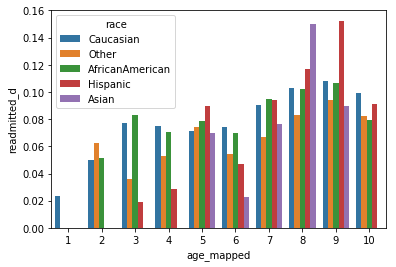

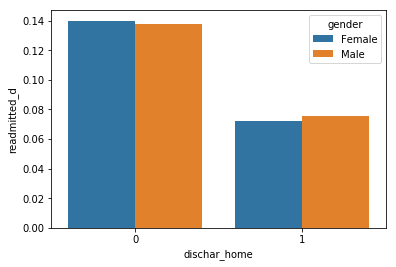

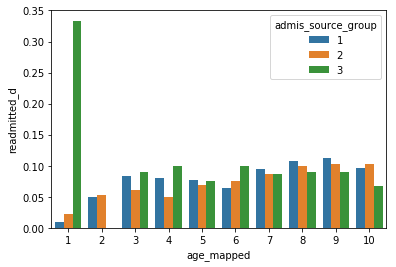

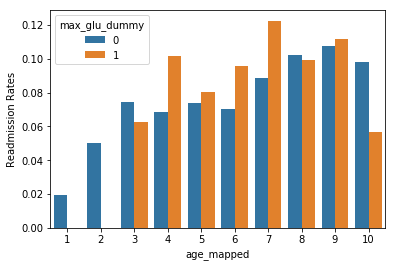

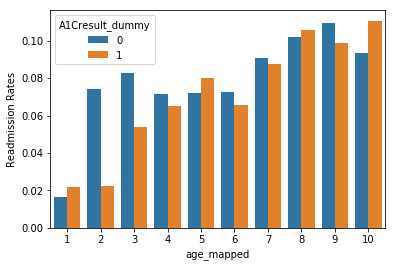

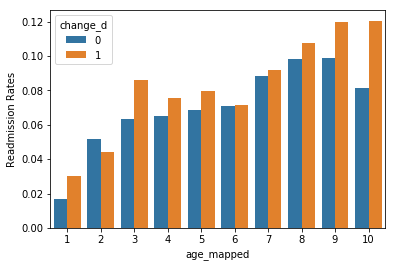

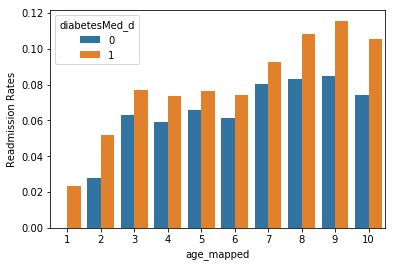

In [16]:
import seaborn as sns

sns.barplot(x="age_mapped",y="readmitted_d", hue='race',data = age_race_df,hue_order=['Caucasian','Other','AfricanAmerican','Hispanic','Asian'])
plt.show()

sns.barplot(x="dischar_home",y="readmitted_d", hue='gender',data = gender_disc_df)
plt.show()

sns.barplot(x="age_mapped",y="readmitted_d", hue='admis_source_group',data = age_adm_df)
plt.show()

g=sns.barplot(x='age_mapped',y='readmitted_d',data=age_glu_df,hue='max_glu_dummy')
plt.ylabel("Readmission Rates")

plt.show()

g=sns.barplot(x='age_mapped',y='readmitted_d',data=age_A1c_df,hue='A1Cresult_dummy')
plt.ylabel("Readmission Rates")

plt.show()

g=sns.barplot(x='age_mapped',y='readmitted_d',data=age_dia_df,hue='change_d')
plt.ylabel("Readmission Rates")

plt.show()

g=sns.barplot(x='age_mapped',y='readmitted_d',data=age_c_df,hue='diabetesMed_d')
plt.ylabel("Readmission Rates")

plt.show()

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


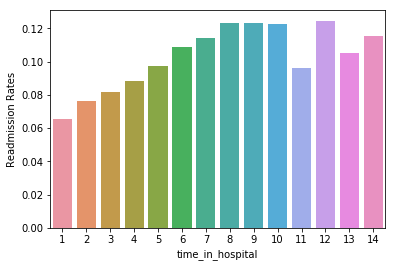

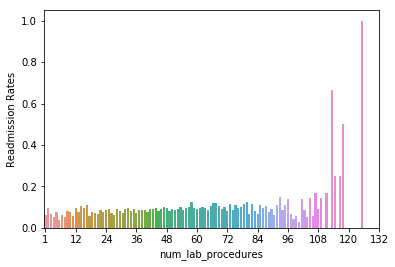

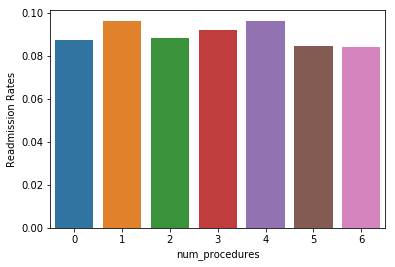

In [17]:
time=cleaned_df.groupby(['time_in_hospital'])['readmitted_d'].mean()
time_df=pd.DataFrame(time)
time_df=time_df.reset_index()

lab=cleaned_df.groupby(['num_lab_procedures'])['readmitted_d'].mean()
lab_df=pd.DataFrame(lab)
lab_df=lab_df.reset_index()

proc=cleaned_df.groupby(['num_procedures'])['readmitted_d'].mean()
proc_df=pd.DataFrame(proc)
proc_df=proc_df.reset_index()

g=sns.barplot(x='time_in_hospital',y='readmitted_d',data=time_df)
plt.ylabel("Readmission Rates")

plt.show()

g=sns.barplot(x='num_lab_procedures',y='readmitted_d',data=lab_df)
plt.ylabel("Readmission Rates")
plt.xticks(np.arange(132,step=11),(1,12,24,36,48,60,72,84,96,108,120,132))
plt.show()

g=sns.barplot(x='num_procedures',y='readmitted_d',data=proc_df)
plt.ylabel("Readmission Rates")
plt.show()

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


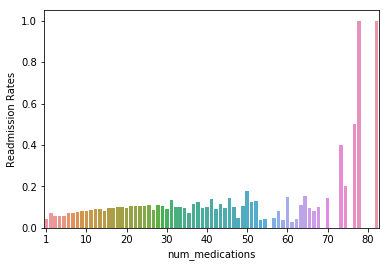

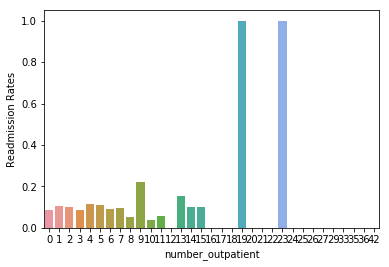

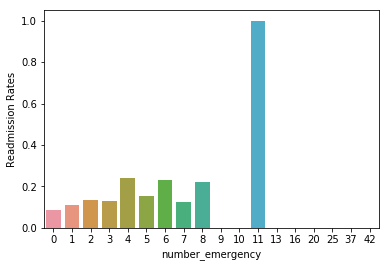

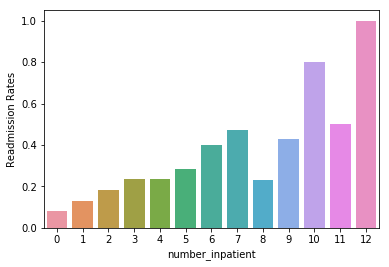

In [18]:
med=cleaned_df.groupby(['num_medications'])['readmitted_d'].mean()
med_df=pd.DataFrame(med)
med_df=med_df.reset_index()

outp=cleaned_df.groupby(['number_outpatient'])['readmitted_d'].mean()
outp_df=pd.DataFrame(outp)
outp_df=outp_df.reset_index()

emerg=cleaned_df.groupby(['number_emergency'])['readmitted_d'].mean()
emerg_df=pd.DataFrame(emerg)
emerg_df=emerg_df.reset_index()

inp=cleaned_df.groupby(['number_inpatient'])['readmitted_d'].mean()
inp_df=pd.DataFrame(inp)
inp_df=inp_df.reset_index()

g=sns.barplot(x='num_medications',y='readmitted_d',data=med_df)
plt.ylabel("Readmission Rates")
plt.xticks(np.arange(80,step=9),(1,10,20,30,40,50,60,70,80))
plt.show()

g=sns.barplot(x='number_outpatient',y='readmitted_d',data=outp_df)
plt.ylabel("Readmission Rates")
plt.show()

g=sns.barplot(x='number_emergency',y='readmitted_d',data=emerg_df)
plt.ylabel("Readmission Rates")
plt.show()

g=sns.barplot(x='number_inpatient',y='readmitted_d',data=inp_df)
plt.ylabel("Readmission Rates")
plt.show()

As suggested by the above figure, senior and white people seems to have higher readmission rates, but gender seems to have no influence of the overall trend. 

For the following plots that explore impact of other variables, I will always display the impact of age.

#### Further questions to ask:

Based on the plots, the distribution of the readmission counts among each feature seems to have a poisson distribution. This is likely to happen since the outcome can also be treated as rare events.

For future inferential statistical analysis, the next question is about what model should be used to fit the data. Whether a logistic regression model or a poisson model is appropriate can be explored later.

Another action step is to further categorize three variables (number of previous inpatient,outpatient,emergency visits) into dummies based on the plots of readmission counts.

### Step Three - Inferential Statistics
First, check if there is correlation between continuous predictors:

In [22]:
cleaned_df[['age_mapped','max_glu_dummy','time_in_hospital', 'num_lab_procedures', 
            'num_procedures','num_medications','number_outpatient', 'number_emergency', 'number_inpatient']].corr()

,age_mapped,max_glu_dummy,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient
age_mapped,1.000000,0.039471,0.127423,0.025128,-0.022669,0.055483,0.026203,-0.047611,0.015395
max_glu_dummy,0.039471,1.000000,0.012897,-0.131848,-0.082444,-0.029145,0.045375,0.024865,0.008444
time_in_hospital,0.127423,0.012897,1.000000,0.332151,0.188339,0.467900,-0.015451,-0.010048,0.063961
num_lab_procedures,0.025128,-0.131848,0.332151,1.000000,0.043834,0.258997,-0.008053,0.015458,0.079723
num_procedures,-0.022669,-0.082444,0.188339,0.043834,1.000000,0.400863,-0.018678,-0.035382,-0.023691
num_medications,0.055483,-0.029145,0.467900,0.258997,0.400863,1.000000,0.027034,0.003194,0.039377
number_outpatient,0.026203,0.045375,-0.015451,-0.008053,-0.018678,0.027034,1.000000,0.094841,0.068743
number_emergency,-0.047611,0.024865,-0.010048,0.015458,-0.035382,0.003194,0.094841,1.000000,0.147727
number_inpatient,0.015395,0.008444,0.063961,0.079723,-0.023691,0.039377,0.068743,0.147727,1.000000


In [24]:
from statsmodels.discrete.discrete_model import Logit
from scipy import stats

cleaned_features=["Caucasian","African_American","Other","Hispanic","Asian",'gender_d', 'age_mapped', 
               'dischar_home','admis_source_group',
               'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
               'num_medications','number_outpatient', 'number_emergency', 
               'number_inpatient', 'CCI', 'number_diagnoses', 
               'max_glu_dummy', 'A1Cresult_dummy','change_d', 'diabetesMed_d']
stats.chisqprob = lambda chisq, cleaned_df: stats.chi2.sf(chisq, cleaned_df)

y=np.array(cleaned_df['readmitted_d']).astype(float)
X=np.array(cleaned_df[cleaned_features]).astype(float)

logit_reg=Logit(y,X)
result=logit_reg.fit()

Optimization terminated successfully.
         Current function value: 0.291692
         Iterations 7


In [25]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                69970
Model:                          Logit   Df Residuals:                    69948
Method:                           MLE   Df Model:                           21
Date:                Wed, 08 Aug 2018   Pseudo R-squ.:                 0.03371
Time:                        21:50:59   Log-Likelihood:                -20410.
converged:                       True   LL-Null:                       -21122.
                                        LLR p-value:                7.442e-289
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -3.1013      0.108    -28.829      0.000      -3.312      -2.890
x2            -3.0731      0.106    -29.018      0.000      -3.281      -2.866
x3            -3.2800      0.126    -25.947      0.000      -3.528      -3.032
x4            -3.1283      0.138    -22.613      0.000      -3.399      -2.857
x5            -3.0864      0.194    -15.871      0.000      -3.468      -2.705
x6             0.0357      0.027      1.316      0.188      -0.017       0.089
x7             0.0488      0.010      5.131      0.000       0.030       0.067
x8            -0.6365      0.030    -21.395      0.000      -0.695      -0.578
x9            -0.0237      0.024     -0.995      0.320      -0.070       0.023
x10            0.0173      0.005      3.326      0.001       0.007       0.028
x11            0.0020      0.001      2.603      0.009       0.001       0.004
x12            0.0015      0.009      0.169      0.866      -0.016       0.019
x13            0.0025      0.002      1.235      0.217      -0.001       0.007
x14           -0.0028      0.012     -0.239      0.811      -0.026       0.021
x15            0.0724      0.021      3.474      0.001       0.032       0.113
x16            0.3444      0.016     21.336      0.000       0.313       0.376
x17            0.0685      0.008      9.106      0.000       0.054       0.083
x18            0.0448      0.008      5.806      0.000       0.030       0.060
x19            0.0971      0.064      1.507      0.132      -0.029       0.223
x20           -0.0891      0.037     -2.393      0.017      -0.162      -0.016
x21           -0.0275      0.031     -0.878      0.380      -0.089       0.034
x22            0.2322      0.038      6.102      0.000       0.158       0.307
==============================================================================
"""

### Step 4. Machine Learning

In [26]:
ml_df=cleaned_df[cleaned_features]
ml_df.describe().loc[['mean','min','max']]

,Caucasian,African_American,Other,Hispanic,Asian,gender_d,age_mapped,dischar_home,admis_source_group,time_in_hospital,...,num_medications,number_outpatient,number_emergency,number_inpatient,CCI,number_diagnoses,max_glu_dummy,A1Cresult_dummy,change_d,diabetesMed_d
mean,0.747349,0.180434,0.043804,0.021438,0.006974,0.467929,7.044005,0.752851,1.540131,4.27326,...,15.665228,0.279548,0.103916,0.176261,1.576876,7.223796,0.047849,0.183579,0.450036,0.761626
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000,3.000000,14.00000,...,81.000000,42.000000,42.000000,12.000000,18.000000,16.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier #linear SVM
from sklearn.naive_bayes import GaussianNB#naive bayes
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=22)

In [28]:
''' First try a simple decision tree classifier '''
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X=np.array(ml_df)
y=np.array(cleaned_df['readmitted_d'])

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=22)

dt_clf=DecisionTreeClassifier(class_weight="balanced")
dt_clf.fit(X_train,y_train)
print(confusion_matrix(dt_clf.predict(X_train),y_train))
print(confusion_matrix(dt_clf.predict(X_test),y_test))
print(classification_report(dt_clf.predict(X_test),y_test)) # obvious overfitting

[[47754     0]
 [    4  4719]]
[[14490  1360]
 [ 1445   198]]
             precision    recall  f1-score   support

          0       0.91      0.91      0.91     15850
          1       0.13      0.12      0.12      1643

avg / total       0.84      0.84      0.84     17493



In [29]:
dt_clf=DecisionTreeClassifier(max_depth=20,class_weight="balanced")
dt_clf.fit(X_train,y_train)
print(confusion_matrix(dt_clf.predict(X_train),y_train))
print(confusion_matrix(dt_clf.predict(X_test),y_test))
print(classification_report(dt_clf.predict(X_test),y_test)) 
''' pruning doesn't help a lot; there might be issues with noise or interaction terms '''

[[39945   363]
 [ 7813  4356]]
[[12292  1103]
 [ 3643   455]]
             precision    recall  f1-score   support

          0       0.77      0.92      0.84     13395
          1       0.29      0.11      0.16      4098

avg / total       0.66      0.73      0.68     17493



" pruning doesn't help a lot; there might be issues with noise or interaction terms "

In [30]:
''' Try Solutoin 1: Feature selection '''
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_1 = SelectKBest(chi2, k=5).fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_1,y,random_state=22)

dt_clf=DecisionTreeClassifier(max_depth=25,class_weight="balanced")
dt_clf.fit(X_train,y_train)
print(confusion_matrix(dt_clf.predict(X_train),y_train))
print(confusion_matrix(dt_clf.predict(X_test),y_test))
print(classification_report(dt_clf.predict(X_test),y_test)) 

[[39772   136]
 [ 7986  4583]]
[[12521  1191]
 [ 3414   367]]
             precision    recall  f1-score   support

          0       0.79      0.91      0.84     13712
          1       0.24      0.10      0.14      3781

avg / total       0.67      0.74      0.69     17493



In [31]:
''' Try Solution 2: Polynomial Terms '''
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
X_poly=poly.fit_transform(X) #276 features

X_2 = SelectKBest(chi2, k=5).fit_transform(X_poly, y)
X_train, X_test, y_train, y_test = train_test_split(X_2,y,random_state=22)

dt_clf=DecisionTreeClassifier(max_depth=25,class_weight="balanced")
dt_clf.fit(X_train,y_train)
print(confusion_matrix(dt_clf.predict(X_train),y_train))
print(confusion_matrix(dt_clf.predict(X_test),y_test))
print(classification_report(dt_clf.predict(X_test),y_test)) 

[[36849   705]
 [10909  4014]]
[[11678  1106]
 [ 4257   452]]
             precision    recall  f1-score   support

          0       0.73      0.91      0.81     12784
          1       0.29      0.10      0.14      4709

avg / total       0.61      0.69      0.63     17493



### Step 4-2. Data Wrangling Updates

In hope to find additional information that was missing with data wrangling

In [32]:
df_raw2=df_raw[['medical_specialty','diag_1',
       'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']]
df_raw2.shape

(101766, 31)

In [33]:
new_df=df_raw2.merge(cleaned_df,how='right', left_index=True,right_index=True)
new_df.shape

(69970, 56)

In [34]:
''' Add new information about whether the drugs were up or down '''

drugs_df=new_df[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']]
up_df=drugs_df.isin(['Up'])
down_df=drugs_df.isin(['Down'])
new_df['med_up']=up_df.sum(axis=1)
new_df['med_down']=down_df.sum(axis=1)

In [35]:
''' Add new information about the physician specialty '''
def specialty_transf(string): 
    if string=='?': 
        return 'unknown'
    if string=='InternalMedicine':
        return 'inter_med'
    if string=='Emergency/Trauma':
        return 'emergency'
    if string== 'Family/GeneralPractice':
        return 'general'
    if string.startswith('Surgery'): 
        return 'surgery'
    if string== 'Cardiology':
        return 'Cardiology'
    else:
        return 'Other_Spec'

new_df['specialty_trans']=new_df['medical_specialty'].apply(specialty_transf)

In [41]:
''' Add new information about the disease '''
new_df['circul1']=new_df['diag_1'].str.match(r'(39[0-9][.]?\d?\d?)|(4[0-5][0-9][.]?\d?\d?)|(785[.]?\d?\d?)')
new_df['circul1']= new_df['circul1'].apply(np.sum)
new_df['respir1']=new_df['diag_1'].str.match(r'(4[6-9][0-9][.]? \d? \d?)|(5[0-1][0-9][.]? \d? \d? |(786[.]? \d? \d?))')
new_df['respir1']= new_df['respir1'].apply(np.sum)

new_df['circul2']=new_df['diag_2'].str.match(r'(39[0-9][.]?\d?\d?)|(4[0-5][0-9][.]?\d?\d?)|(785[.]?\d?\d?)')
new_df['circul2']= new_df['circul2'].apply(np.sum)
new_df['respir2']=new_df['diag_2'].str.match(r'(4[6-9][0-9][.]? \d? \d?)|(5[0-1][0-9][.]? \d? \d? |(786[.]? \d? \d?))')
new_df['respir2']= new_df['respir2'].apply(np.sum)

new_df['circul3']=new_df['diag_3'].str.match(r'(39[0-9][.]?\d?\d?)|(4[0-5][0-9][.]?\d?\d?)|(785[.]?\d?\d?)')
new_df['circul3']= new_df['circul3'].apply(np.sum)
new_df['respir3']=new_df['diag_3'].str.match(r'(4[6-9][0-9][.]? \d? \d?)|(5[0-1][0-9][.]? \d? \d? |(786[.]? \d? \d?))')
new_df['respir3']= new_df['respir3'].apply(np.sum)

new_df['circul']=new_df['circul1']+new_df['circul2']+new_df['circul3']
new_df['circulatory']=new_df['circul'].apply(lambda x:1 if x>0 else 0)
new_df['respir']=new_df['circul1']+new_df['circul2']+new_df['circul3']
new_df['respiratory']=new_df['respir'].apply(lambda x:1 if x>0 else 0)

In [42]:
''' Group Age into below 30,30-60,and 60 above '''
def age_transf(string):
    if string in (0,1,2):
        return 1
    if string in (3,4,5):
        return 2
    if string in (6,7,8,9,10): 
        return 3

new_df['age_update']=new_df['age_mapped'].apply(age_transf)
new_df['age_update'].value_counts()

3    58642
2    10641
1      687
Name: age_update, dtype: int64

In [43]:
encode_features=['max_glu_serum','A1Cresult','specialty_trans']
df_temp=pd.get_dummies(new_df[encode_features])
df_temp.columns
new_df[['max_glu_serum_>200', 'max_glu_serum_>300', 'max_glu_serum_None',
        'max_glu_serum_Norm', 'A1Cresult_>7', 'A1Cresult_>8', 'A1Cresult_None',
        'A1Cresult_Norm','specialty_trans_Other_Spec', 'specialty_trans_emergency',
        'specialty_trans_Cardiology','specialty_trans_general', 'specialty_trans_inter_med',
        'specialty_trans_surgery','specialty_trans_unknown']]=pd.get_dummies(new_df[encode_features])

In [44]:
new_df.columns

Index(['medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'race', 'Caucasian',
       'African_American', 'Other', 'Hispanic', 'Asian', 'gender', 'gender_d',
       'age_mapped', 'dischar_home', 'admis_source_group', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'CCI',
       'number_diagnoses', 'max_glu_dummy', 'A1Cresult_dummy', 'change_d',
       'diabetesMed_d', 'readmitted_d', 'med_up', 'med_dow

In [45]:
updated_features=['Caucasian','African_American', 'Other', 'Hispanic', 'Asian',
                 'dischar_home', 'admis_source_group', 'time_in_hospital',
                  'num_lab_procedures', 'num_procedures', 'num_medications',
                  'number_outpatient', 'number_emergency', 'number_inpatient', 'CCI',
                  'number_diagnoses','change_d','diabetesMed_d','med_up', 'med_down',
                  'circulatory', 'respiratory', 'age_update',
                  'max_glu_serum_>200','max_glu_serum_>300', 'max_glu_serum_None', 
                  'max_glu_serum_Norm','A1Cresult_>7', 'A1Cresult_>8', 
                  'A1Cresult_None', 'A1Cresult_Norm','specialty_trans_Other_Spec', 
                  'specialty_trans_emergency','specialty_trans_Cardiology', 
                  'specialty_trans_general','specialty_trans_inter_med', 
                  'specialty_trans_surgery','specialty_trans_unknown']
df_updated=new_df[updated_features]

In [46]:
try_features=['num_medications','specialty_trans_emergency','specialty_trans_surgery',
             'dischar_home','med_up', 'med_down','A1Cresult_>8', 'admis_source_group']
df_try=df_updated[try_features]

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X=np.array(df_updated)
y=np.array(new_df['readmitted_d'])

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=22)

In [56]:
dt_clf=DecisionTreeClassifier(max_depth=25,class_weight="balanced")
dt_clf.fit(X_train,y_train)
print(confusion_matrix(dt_clf.predict(X_train),y_train))
print(confusion_matrix(dt_clf.predict(X_test),y_test))
print(classification_report(dt_clf.predict(X_test),y_test))

[[43247    43]
 [ 4511  4676]]
[[13108  1214]
 [ 2827   344]]
             precision    recall  f1-score   support

          0       0.82      0.92      0.87     14322
          1       0.22      0.11      0.15      3171

avg / total       0.71      0.77      0.74     17493



In [57]:
rf_clf=RandomForestClassifier(max_depth=25,n_estimators=25,max_features=5,class_weight="balanced")
rf_clf.fit(X_train,y_train)
print(confusion_matrix(rf_clf.predict(X_train),y_train))
print(confusion_matrix(rf_clf.predict(X_test),y_test))
print(classification_report(rf_clf.predict(X_test),y_test))

[[47560   375]
 [  198  4344]]
[[15775  1525]
 [  160    33]]
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     17300
          1       0.02      0.17      0.04       193

avg / total       0.98      0.90      0.94     17493



#### It proves that if you have many noises in your data, RandomForest does poorer than DecisionTree.

In [64]:
''' Still, conduct feature selectin '''
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_new = SelectKBest(chi2, k=5).fit_transform(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_new,y_train,random_state=22)

dt_clf2=DecisionTreeClassifier(max_depth=25,class_weight="balanced")
dt_clf2.fit(X_train,y_train)
print(confusion_matrix(dt_clf2.predict(X_train),y_train))
print(confusion_matrix(dt_clf2.predict(X_test),y_test))
print(classification_report(dt_clf2.predict(X_test),y_test))

[[30745    78]
 [ 5069  3465]]
[[9631  967]
 [2313  209]]
             precision    recall  f1-score   support

          0       0.81      0.91      0.85     10598
          1       0.18      0.08      0.11      2522

avg / total       0.69      0.75      0.71     13120



In [65]:
''' Try Random Undersampling '''
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus= RandomUnderSampler(ratio='auto', return_indices=False, random_state=None, replacement=False)

X=np.array(df_updated)
y=np.array(new_df['readmitted_d'])

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=22)

X_resamp, y_resamp = rus.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_resamp)))

Resampled dataset shape Counter({0: 4719, 1: 4719})


In [66]:
dt_clf=DecisionTreeClassifier(max_depth=25,class_weight="balanced")
dt_clf.fit(X_train,y_train)
print(confusion_matrix(dt_clf.predict(X_train),y_train))
print(confusion_matrix(dt_clf.predict(X_test),y_test))
print(classification_report(dt_clf.predict(X_test),y_test))

[[43180    42]
 [ 4578  4677]]
[[13078  1201]
 [ 2857   357]]
             precision    recall  f1-score   support

          0       0.82      0.92      0.87     14279
          1       0.23      0.11      0.15      3214

avg / total       0.71      0.77      0.73     17493

